# **Example 03: Denoising on complex-valued data with complex-valued operations**
We first define the data pipelines to feed the data into training, validation and test set. The MNIST database is used for showcasing. Since MNIST are real-valued images, a phase is simulated and added to the images to generate a complex-valued input. A white Gaussian noise is simulated retrospectively and added to the data. The task of the network is to denoise the images with complex-valued operations. You can compare the different processing to the pure real-valued case (Example 01) and to handling the complex-valued data in 2 real-valued channels (Example 03).

To enable GPU support in Google Colab, please go to `Edit -> Notebook settings` and select `GPU` as hardware accelerator.

In [ ]:
# inspect the available GPU hardware
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

## Database pipeline
Here starts the main part of the script. First define the data pipelines (in the form of generator functions) for training, validation and test set. Retrospective noise simulation is performed inside the generator functions.

In [1]:
import tensorflow as tf
import numpy as np
import os
import datetime
import tutorial
import merlintf

# initialize some parameters
noise_level = 0.5  # simulated additive white Gaussian noise level

# Data Generators (Data pipeline) for complex-valued data
# training set
training_generator = tutorial.datasets.ComplexDataGeneratorMNIST(batch_size=32, 
                                    noise_level=noise_level,
                                    shuffle=True,
                                    mode='train')

# validation set
validation_generator = tutorial.datasets.ComplexDataGeneratorMNIST(batch_size=32, 
                                    noise_level=noise_level,
                                    shuffle=False,
                                    mode='val')

# test set
# ideally testing should be performed on real noisy cases and not simulated ones
test_generator = tutorial.datasets.ComplexDataGeneratorMNIST(batch_size=1,   
                                    shuffle=False,
                                    mode='test')

print('Training batches to process:', len(training_generator))
print('Validation batches to process:', len(validation_generator))
print('Test samples to process:', len(test_generator))

Training batches to process: 1500
Validation batches to process: 375
Test samples to process: 10000


## Model
Define the CNN model with its corresponding inputs and outputs.


### 3-layer convolutional neural network (CNN)


In [2]:
# Generate Model
# Let's start with a 3-layer CNN
input = tf.keras.Input(shape=(28, 28, 1), dtype='complex64')  # define input layer and its shape, complex-valued tensors
activation = 'cReLU'  # select activation function: complex-valued ReLU
# convolutional layer 1: Complex-valued convolution
conv_out1 = merlintf.keras.layers.ComplexConv2D(filters=4,                # output channels, N_fout
                                kernel_size=(3,3),              # kernel size along x and y
                                strides=(1,1),                  # stride performed along x and y
                                padding='SAME',                 # padding of input to adjust output size
                                use_bias=True,                  # learn bias values for conv layer
                                activation=activation)(input)   # apply activation function after conv operation
# convolutional layer 2: Complex-valued convolution
conv_out2 = merlintf.keras.layers.ComplexConv2D(filters=4,
                                kernel_size=(3,3),
                                strides=(1,1),
                                padding='SAME',
                                use_bias=True,
                                activation=activation)(conv_out1)
# convolutional layer 3: Complex-valued convolution
output    = merlintf.keras.layers.ComplexConv2D(filters=1,
                                kernel_size=(3,3),
                                strides=(1,1),
                                padding='SAME',
                                use_bias=True,
                                activation=activation)(conv_out2)

# instantiate a keras functional model: combine layers into a model with specified inputs and outputs
model = tf.keras.Model(input, output, name='3layerCNNComplex')

# print model overview
model.summary()

Model: "3layerCNNComplex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
complex_conv2d (ComplexConv2 (None, 28, 28, 4)         80        
_________________________________________________________________
complex_conv2d_1 (ComplexCon (None, 28, 28, 4)         296       
_________________________________________________________________
complex_conv2d_2 (ComplexCon (None, 28, 28, 1)         74        
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


### 3-layer residual convolutional neural network (CNN)

In [2]:
# Generate Model
# Let's start with a residual 3-layer CNN
input = tf.keras.Input(shape=(28, 28, 1), dtype='complex64')  # define input layer and its shape, complex-valued tensors
activation = 'cReLU'  # select activation function: complex-valued ReLU
# convolutional layer 1: Complex-valued convolution
conv_out1 = merlintf.keras.layers.ComplexConv2D(filters=4,                # output channels, N_fout
                                kernel_size=(3,3),              # kernel size along x and y
                                strides=(1,1),                  # stride performed along x and y
                                padding='SAME',                 # padding of input to adjust output size
                                use_bias=True,                  # learn bias values for conv layer
                                activation=activation)(input)   # apply activation function after conv operation
# convolutional layer 2: Complex-valued convolution
conv_out2 = merlintf.keras.layers.ComplexConv2D(filters=4,
                                kernel_size=(3,3),
                                strides=(1,1),
                                padding='SAME',
                                use_bias=True,
                                activation=activation)(conv_out1)
# convolutional layer 3: Complex-valued convolution
residual    = merlintf.keras.layers.ComplexConv2D(filters=1,
                                kernel_size=(3,3),
                                strides=(1,1),
                                padding='SAME',
                                use_bias=True,
                                activation=activation)(conv_out2)
# residual connection
output = tf.keras.layers.Add()([input, residual])

# instantiate a keras functional model: combine layers into a model with specified inputs and outputs
model = tf.keras.Model(input, output, name='Residual3layerCNNComplex')

# print model overview
model.summary()

Model: "Residual3layerCNNComplex"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
complex_conv2d (ComplexConv2D)  (None, 28, 28, 4)    80          input_1[0][0]                    
__________________________________________________________________________________________________
complex_conv2d_1 (ComplexConv2D (None, 28, 28, 4)    296         complex_conv2d[0][0]             
__________________________________________________________________________________________________
complex_conv2d_2 (ComplexConv2D (None, 28, 28, 1)    74          complex_conv2d_1[0][0]           
___________________________________________________________________________

### Build model
Compile the model, assign an optimizer, loss function and validation metrics. Prepare some keras callbacks to monitor training progress.

In [3]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),      # used optimizer with chosen learning rate
              loss='mse',                                                   # loss function (note: TF can perform real-valued mse loss on complex-valued input) 
              metrics=['mse', 'mae'])                                       # evaluation metrics (for training and validation set)

# define callbacks to monitor model
keras_callbacks = tutorial.get_callbacks(validation_generator, model)

## Tensorboard
Start the Tensorboard [optional] to monitor training progress and display validation outputs.

In [ ]:
# start Tensorboard
%load_ext tensorboard
%tensorboard --logdir=logs

## Training
Train the configured and compiled model. Monitor training progress with validation set.

In [4]:
# train model with training set and evaluate its performance with the validation set
model.fit(training_generator,                       # training set
          validation_data=validation_generator,     # validation set
          epochs=3,                                 # number of epochs to train the model
          callbacks=keras_callbacks)                # callbacks to monitor or control training

Epoch 1/3
1500/1500 [==============================] - 15s 9ms/step - loss: 0.0457 - mse: 0.0410 - mae: 0.0726 - val_loss: 0.0342 - val_mse: 0.0317 - val_mae: 0.0531
Epoch 2/3
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0338 - mse: 0.0315 - mae: 0.0521 - val_loss: 0.0331 - val_mse: 0.0310 - val_mae: 0.0505
Epoch 3/3
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0332 - mse: 0.0312 - mae: 0.0505 - val_loss: 0.0327 - val_mse: 0.0308 - val_mae: 0.0499


## Testing
Test the trained model to predict a denoised output and to display performance (metrics) on test set.

In [5]:
# predict with trained model
predicted_output = model.predict(test_generator)

# evaluate trained model
loss_metric_test = model.evaluate(test_generator)

10000/10000 [==============================] - 26s 3ms/step - loss: 0.0311 - mse: 0.0301 - mae: 0.0454


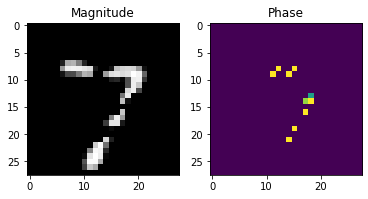

In [7]:
# display the predicted output
import matplotlib.pyplot as plt
icase = 0  # display the first example
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.squeeze(np.abs(predicted_output[icase,])), cmap='gray')
plt.title('Magnitude')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(np.angle(predicted_output[icase,])))
plt.title('Phase')
plt.show()